## Understanding Pytorch Tutorial
__[Towards Data Science Tutorial](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e)__

### Simple Regression Problem
Linear regression with a single feature x.<br>
Steps:
1. generate data, label, and add noise
2. split the data into training and validation 80/20


In [1]:
import numpy as np

np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

#shuffle indexes
index = np.arange(100)
np.random.shuffle(index)

# get first 80 values for training
train_index = index[:80]

# get last 20 for validation
validate_index = index[80:]

x_train, y_train = x[train_index], y[train_index]
x_validate, y_validate = x[validate_index], y[validate_index]

In [2]:
# print plots of the data
import matplotlib.pyplot as plt 

# Create Figure and Subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey=False, dpi=120)

# Plot
ax1.plot(x_train, y_train, 'g.')  # green dots
ax2.plot(x_validate, y_validate, 'b.')  # blue dots

# Title, X and Y labels, X and Y Lim
ax1.set(title='Generated Data: Train', xlabel='x axis', ylabel='y axis')
ax2.set(title='Generated Data: Validate', xlabel='x axis', ylabel='y axis')
# ax2.yaxis.set_ticks_position('none') 
plt.tight_layout()
plt.show()


<Figure size 1200x480 with 2 Axes>

### Gradient Descent
* Compute the loss
    * regression uses Mean Squared Error (MSE)
    * batch gradient descent uses all the training points
    * stochastic gradient descent uses one point in time
    * any other size is mini-batch gradient descent
* Compute the gradients
    * how much does MSE loss change when we vary a parameter?
    * use partial derivatives of each parameter
* Update the parameters
    * use the gradients to update the parameters 
    * reverse the sign to minimize loss (rather than maximize)
    * learning rate: multiplicative factor to apply to the gradient for the update
* Repeat for n epochs...

### Implement Linear Regression in Numpy
Training:
* random initiation of parameters/weights
* initialization of hyperparameters

Use random seed for reproducibililty<br>

__Training steps for each epoch:__<br>

1. compute model predictions
2. compute the loss
3. compute the gradients
4. updated the parameters

In [3]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42) # use seed for reproducibility
a = np.random.randn(1)
b = np.random.randn(1)

print('a and b after initialization:')
print(a,b)

# set the learning rate (choosing rate not in this tutorial)
lr = 1e-1

# set the number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # compute the predicted output of the model
    yhat = a + b * x_train
    
    # get the error (using batch gradient descent)
    error = (y_train - yhat)
    
    # compute the mean squared error
    loss = (error**2).mean()
    
    # compute the gradients for a and b
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()
    
    # update the parameters using gradients and learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad
    
print('a and b after linear regression:')
print(a,b)

a and b after initialization:
[0.49671415] [-0.1382643]
a and b after linear regression:
[1.02354094] [1.96896411]


In [4]:
# use skikit-learn to check/ verify it is correct
from sklearn.linear_model import LinearRegression

linr = LinearRegression()
linr.fit(x_train, y_train)
print('a and b scikit linear regression:')
print(linr.intercept_, linr.coef_[0])

a and b scikit linear regression:
[1.02354075] [1.96896447]


### What is a tensor?
- scalar: no dimensions
- vector: one dimension
- matrix: two dimensions
- tensor: more than 2 dimensions<br>

Can refer to vectors/matrices as tensors.

### Data, Devices and CUDA
- can convert from a numpy array to a torch tensor
- can send the tensor to the gpu or whatever you specify

You cannot use cuda in a virutal environment without hacky mods.  Will not implement here.

In [5]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

# uses cuda if available, if not - uses cpu.  gpu not avaibable in vrtual box.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# convert numpy arrays to torch tensor
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# you cannot turn a gpu tensor back into a numpy array without moving
# it to the cpu first with cpu()

# check werhere the array/tensors are stored (cpu vs gpu)
# use type() or .type()
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.FloatTensor


### Create torch and assign to device
You can create a cpu torch and assign it to the gpu later.  But it is better practice to create and assign the torch
at the same time.

In [6]:
#  create parameter a and b and use REQUIRES_GRAD=TRUE to apply gradient descent
torch.manual_seed(42)

# use the device argument at creation to set the device
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)


print(a,b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


### Autograd
Autograd is the automatic differentiation tool in Pytorch. <br>
torch.autograd.backward() computes the sm of the gradients of given tensors w.r.t graph leaves<br>
each time the gradients are used to update the parameters, they need to be zeroed out with zero_()

In [7]:
#  use backward() and zero_() methods to update the gradients

# parameters from above, copied here for reference
# lr = 1e-1
# n_epochs = 1000

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()
    
    # use loss.backward() to get gradients
    loss.backward()

    # need to use no_grad to keep the update (b/c dynamic computation graph)
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()
    
print(a, b)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


### Computation Graphs

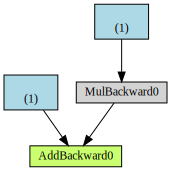

In [11]:
make_dot(yhat)
# blue boxes: tensors use as parameters, the ones to compute gradients for
# gray box:   python operation that involves gradient computing tensor or its dependencies
# green box:  same as gray, but the starting point for the computation of gradients

# anything not used in computing gradients is not show.

### Optimizing Parameters
Pytorch has optimezers like SGD (stochatic gradient descent) and Adam.<br>
The optimizer uses the parameters we want to update, the learning rate (and other hyperparameters) and updates using the  step() method.<br>


In [12]:
# from above, reseting all the variables...
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

lr = 1e-1
n_epochs = 1000

# set up the optimizer
optimizer = optim.SGD([a,b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # no more manually calculating the gradients
    loss.backward()    
    
    # no more manual updates
    optimizer.step()
    
    # use the optimizer to let the gradients go...
    optimizer.zero_grad()
    
print(a,b)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


### Loss Computation
This doesn't need to be done manually. <br>
MSE is used for linear regression, there are many others implemented __[See Documentation](https://pytorch.org/docs/stable/nn.html#loss-functions)__.  

In [13]:
# from above, reseting all the variables...
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# set up the optimizer
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    
    # No more manual loss
    loss = loss_fn(y_train_tensor, yhat)

    # no more manually calculating the gradients
    loss.backward()    
    
    # no more manual updates
    optimizer.step()
    
    # use the optimizer to let the gradients go...
    optimizer.zero_grad()
print(a, b)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


### The Model Class

The model class is a python class that inherits from module.

Must implement:

- \__init__(self):  defines the parts of the model (parameters)<br>
- forward(self,x):  preforms the computation, it outputs a prediction given the input x

The whole model should be called, not forward.

In [15]:

# using the nn.Module to create a linear regression.

class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        # this tells pytorch that these tensors should be part of the parameters for the model
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x

In [16]:
# call the model

torch.manual_seed(42)

# Now we can create a model and send it at once to the device
# if the parameters are in the gpu, then the model must be in the gpu too
model = ManualLinearRegression().to(device)
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # puts the model in training mode, does not perform a training step
    # some models behave differently in trainging/testing (ie Dropout)
    model.train()

    # replaces the manual training
    yhat = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict([('a', tensor([0.3367])), ('b', tensor([0.1288]))])
OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


In [17]:
 # nested linear model
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

### Sequential models

The output of one layer is fed into the next.

### Training Step
Neaten up the code to perform a training step:<br>
Function that takes the optimizer, loss, and model, then returns another function that performs a training step.<br>
The function takes features and labels as arguments and returns loss.<br>
The function can be called from our training loop.


In [18]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
# Checks model's parameters
print(model.state_dict())

OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


### PyTorch Dataset

Implement the Dataset class: a list of tuples (features, labels)<br>
- \__init__(self): takes in arguments needed to build a list of tuples (can be csv, two tensors...)
- \__get_item__(self, index): indexes the dataset and returns a tuple.  Can be used to load data items on demand if the set is large.
-  \__len__(self): returns the size of the whole dataset.

### PytTorch DataLoader

PyTorch DataLoader can slice our dataset into mini-batches. <br>
It will act like an iterator and can shuffle or not, and fetch a different batch each time.

In [22]:
# a custom dataset that takes two tensors as arguments (features, labels)
from torch.utils.data import Dataset, TensorDataset

class CustomDataset(Dataset):  # inherits the dataset class
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)
    
# Dont want to use gpu tensors because the can eat up the ram in the gpu
# we don't want to load an entire dataset into the gpu...
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])



(tensor([0.7713]), tensor([2.4745]))
(tensor([0.7713]), tensor([2.4745]))


In [24]:
# import the dataLoader
from torch.utils.data import DataLoader

#set up the dataloader
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

In [25]:
losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
print(model.state_dict())

OrderedDict([('a', tensor([1.0249])), ('b', tensor([1.9695]))])


### Random split
Performs a training-validation split- must be applied to the whole dataset.<br>
Then build a DataLoader for each subset.

In [26]:
from torch.utils.data.dataset import random_split

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

### Evaluation

Add the evaluation of the model in the training loop (validation loss)<br>
Add another inner loop to handle the mini-batches from the validation loader.<br>
Make predictions about the model.<br>
Compute the loss.<br>

---
Gradients belong in training, not in validation.<br>
eval() puts the modelin evaluation. <br>

In [27]:
losses = []
val_losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

print(model.state_dict())

OrderedDict([('a', tensor([1.0340])), ('b', tensor([1.9253]))])
